In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
# Problem 1

a = 1.0
b = 3.0
delta = 1e-10
t_final = 20.0
H_init = 20.0
n_seq = [2, 4, 6, 8]

def f(t, y):
    x, yy = y
    # avoid overflow by clamping intermediate values
    if abs(x) > 1e6 or abs(yy) > 1e6:
        return np.zeros(2)
    dx = 1.0 - (b + 1.0) * x + a * x * x * yy
    dy = b * x - a * x * x * yy
    if np.any(np.isnan([dx, dy])) or np.any(np.isinf([dx, dy])):
        return np.zeros(2)
    return np.array([dx, dy])

def modified_midpoint(y0, t0, H, n):
    h = H / n
    y_nm2 = y0.copy()
    y_nm1 = y0 + h * f(t0, y0)
    if n == 1:
        return y_nm1
    t = t0 + h
    for _ in range(2, n+1):
        fi = f(t, y_nm1)
        if np.any(np.isnan(fi)) or np.any(np.isinf(fi)):
            return y_nm1
        y_i = y_nm2 + 2.0 * h * fi
        y_nm2, y_nm1 = y_nm1, y_i
        t += h
    return y_nm1


In [12]:
def extrapolate_with_history(Y, x):
    m = len(Y)
    table = [[None]*m for _ in range(m)]
    for i in range(m):
        table[i][0] = Y[i].copy()
    for j in range(1, m):
        for i in range(m - j):
            xi, xj = x[i], x[i+j]
            Ai, Aj = table[i][j-1], table[i+1][j-1]
            table[i][j] = ((-xj) * Ai + xi * Aj) / (xi - xj)
    return [table[0][j] for j in range(m)]

def bulirsch_stoer_step(y, t, H, delta, n_seq):
    endpoints, hsquared = [], []
    for n in n_seq:
        Yn = modified_midpoint(y, t, H, n)
        endpoints.append(Yn)
        h = H / n
        hsquared.append(h*h)
        diag = extrapolate_with_history(endpoints, hsquared)
        if len(diag) >= 2:
            y_extrap, y_prev = diag[-1], diag[-2]
            tol = delta * H
            err_vec = np.abs(y_extrap - y_prev)
            scale = np.maximum(1.0, np.abs(y_extrap))
            err_scaled = err_vec / (tol * scale)
            err = np.max(err_scaled)
            if err <= 1.0:
                return True, y_extrap, err, n
    return False, None, None, None

def integrate():
    t, y = 0.0, np.array([0.0, 0.0])
    H = H_init
    ts, ys, boundaries_t = [t], [y.copy()], [t]
    step_count = 0
    while t < t_final - 1e-14:
        if t + H > t_final:
            H = t_final - t
        accepted = False
        while not accepted:
            ok, y_new, err, used_n = bulirsch_stoer_step(y, t, H, delta, n_seq)
            step_count += 1
            if ok:
                t += H
                y = y_new.copy()
                ts.append(t)
                ys.append(y.copy())
                boundaries_t.append(t)
                order = 2 * (used_n // 2)
                safety = 0.9
                fac = 4.0 if err == 0 else safety * (1.0/err)**(1.0/(order+1))
                fac = np.clip(fac, 0.5, 4.0)
                H_new = H * fac
                H = H_new
                accepted = True
            else:
                H /= 2.0
                if H < 1e-16:
                    raise RuntimeError("Step size underflow.")
    return np.array(ts), np.array(ys), boundaries_t

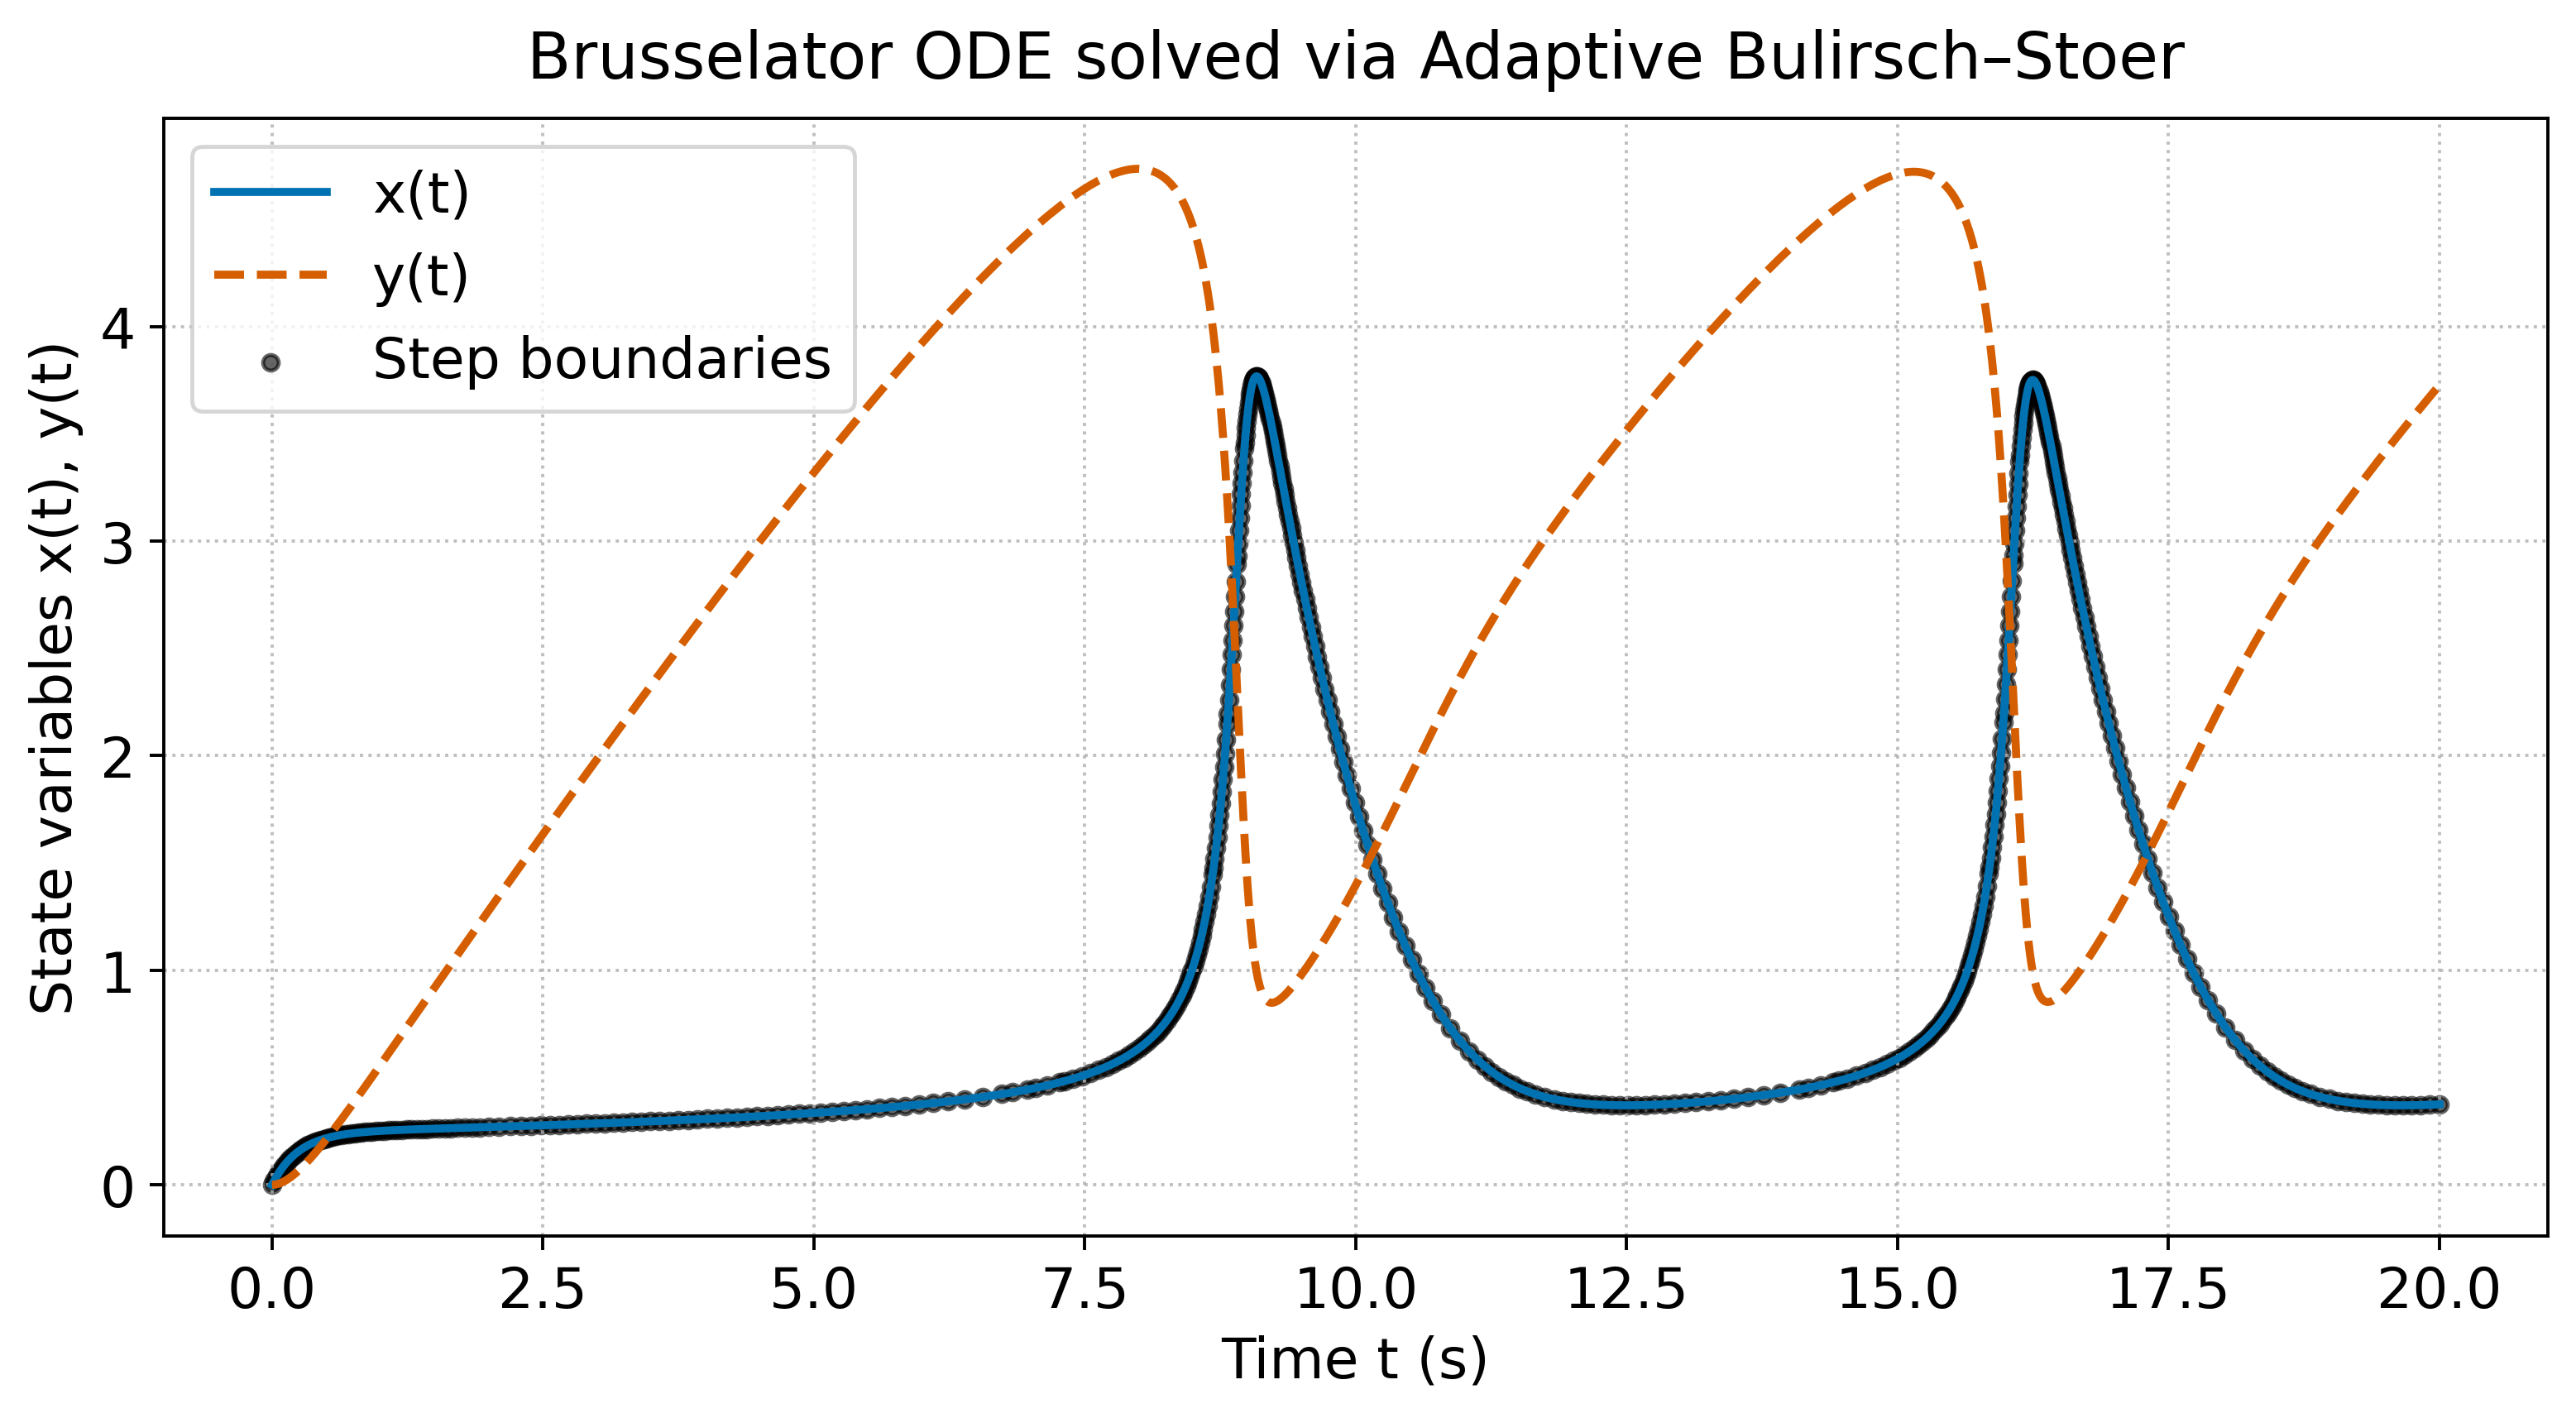

In [18]:
ts, ys, boundaries = integrate()
x_vals, y_vals = ys[:,0], ys[:,1]

fig, ax = plt.subplots(figsize=(9, 5), dpi=350)
ax.plot(ts, x_vals, color="#0072B2", linewidth=2, label="x(t)")
ax.plot(ts, y_vals, color="#D55E00", linewidth=2, linestyle="--", label="y(t)")
ax.scatter(boundaries, np.interp(boundaries, ts, x_vals), s=15, color="k", alpha=0.6, label="Step boundaries")

ax.set_title("Brusselator ODE solved via Adaptive Bulirsch–Stoer", fontsize=16, pad=10)
ax.set_xlabel("Time t (s)", fontsize=14)
ax.set_ylabel("State variables x(t), y(t)", fontsize=14)
ax.legend(frameon=True, loc="best",fontsize=14)
ax.grid(True, which="both", linestyle=":", linewidth=0.8, alpha=0.8)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig("figs/brusselator.png")

In [46]:

from math import sqrt
from scipy import optimize  # used for bracketing/solving v for given r_peri


G = 1.0     
M = 1.0     
r_schw = 1e-7    
R_unit_pc = 100.0  # parsecs per distance unit

M_phys_Msun_default = 1e8


def acceleration(pos, vel, A=0.0, B=0.0):
    """
    Compute acceleration vector: gravity + dynamical friction
    
    pos: 2-array (x,y)
    vel: 2-array (vx,vy)
    A, B: dynamical friction parameters (numbers)
          acceleration from DF is: a_df = - A/(v^3 + B) * v_vec
    returns: 2-array acceleration
    """
    x, y = pos
    rvec = np.array([x, y], dtype=float)
    r = np.linalg.norm(rvec)
    if r == 0:
        return np.zeros(2)
    # gravitational acceleration (central)
    a_grav = -G * M * rvec / (r**3)
    # dynamical friction acceleration
    v = np.linalg.norm(vel)
    # protect from division by zero or overflow
    denom = (v**3 + B)
    if denom <= 0 or not np.isfinite(denom):
        a_df = np.zeros(2)
    else:
        a_df = - (A / denom) * vel
    return a_grav + a_df


def rk4_step(y, t, h, deriv):
    k1 = deriv(t, y)
    k2 = deriv(t + 0.5*h, y + 0.5*h*k1)
    k3 = deriv(t + 0.5*h, y + 0.5*h*k2)
    k4 = deriv(t + h, y + h*k3)
    return y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def deriv_from_posvel(t, y_vec, A=0.0, B=0.0):
    """
    Convert state vector y_vec = [x, y, vx, vy] to derivative [vx, vy, ax, ay]
    using current A,B for DF.
    """
    x, y, vx, vy = y_vec
    pos = np.array([x, y], dtype=float)
    vel = np.array([vx, vy], dtype=float)
    a = acceleration(pos, vel, A=A, B=B)
    return np.array([vx, vy, a[0], a[1]], dtype=float)

def adaptive_rk4_step(y, t, h, deriv_func, tol_per_unit_time, A=0.0, B=0.0):
    # one big step
    y_big = rk4_step(y, t, h, lambda tt, yy: deriv_func(tt, yy, A=A, B=B))
    # two half steps
    y_half = rk4_step(y, t, h/2.0, lambda tt, yy: deriv_func(tt, yy, A=A, B=B))
    y_two = rk4_step(y_half, t + h/2.0, h/2.0, lambda tt, yy: deriv_func(tt, yy, A=A, B=B))
    # error estimate:
    err_vec = (y_two - y_big) / 15.0  # RK4 has error constant ~ 1/15 for step-doubling
    # tolerance scaled to step length
    tol_vec = tol_per_unit_time * h * np.maximum(1.0, np.abs(y_two))
    tol_vec = np.maximum(tol_vec, 1e-16)
    err_scaled = np.abs(err_vec) / tol_vec
    err_norm = np.max(err_scaled)

    if not np.isfinite(err_norm):
        return False, None, h/2.0, np.inf
    if err_norm <= 1.0:
        # grow h slightly depending on error
        safety = 0.9
        order = 4
        if err_norm == 0:
            fac = 2.0
        else:
            fac = safety * (1.0/err_norm)**(1.0/(order+1))
        fac = np.clip(fac, 0.5, 2.0)
        h_new = h * fac
        return True, y_two, h_new, err_norm
    else:
        # reject, reduce h
        safety = 0.9
        order = 4
        fac = safety * (1.0/err_norm)**(1.0/(order+1))
        fac = np.clip(fac, 0.1, 0.5)
        h_new = h * fac
        return False, None, h_new, err_norm


def compute_pericenter_from_v(v0):
    r0 = 1.0
    # specific energy
    E = 0.5 * v0**2 - G*M / r0
    # specific angular momentum
    h = r0 * v0
    # eccentricity
    arg = 1.0 + 2.0 * E * h**2 / (G**2 * M**2)
    if arg < 0:
        # numerical/clamped (shouldn't occur for bound orbits)
        e = np.sqrt(max(0.0, arg))
    else:
        e = np.sqrt(arg)
    r_p = h**2 / (G*M * (1.0 + e))
    return r_p, e

def find_v_for_pericenter(rp_target, v_min=1e-6, v_max=1.413, tol=1e-12):
    def f(v):
        rp, e = compute_pericenter_from_v(v)
        return rp - rp_target
    # make sure bracket has opposite signs
    # if f(v_min) already < 0 and f(v_max) > 0 adjust ends
    a = v_min
    b = v_max
    fa = f(a)
    fb = f(b)
    # If signs do not bracket, expand v_min downward or v_max upward a bit:
    if fa * fb > 0:
        # try scanning to find bracket
        vs = np.linspace(v_min, v_max, 200)
        vals = [f(v) for v in vs]
        sign_changes = [i for i in range(len(vals)-1) if vals[i]*vals[i+1] <= 0]
        if len(sign_changes) == 0:
            raise RuntimeError("Could not bracket pericenter target. Try different bounds.")
        i = sign_changes[0]
        a, b = vs[i], vs[i+1]
        fa, fb = f(a), f(b)
    # bisection
    for _ in range(100):
        m = 0.5*(a+b)
        fm = f(m)
        if abs(fm) < tol:
            return m
        if fa*fm <= 0:
            b = m
            fb = fm
        else:
            a = m
            fa = fm
    return 0.5*(a+b)


def integrate_orbit(y0, t0, h_init, t_final, delta, A, B, r_stop, max_steps=200000, print_steps=False, stop_after_orbit=False):
    """
    Adaptive RK4 integrator for black hole binary orbits.
    Includes dynamical friction and optional early termination
    after completing one full orbit (Δphi ≈ 2π).
    """

    def acceleration(y):
        x, yv, vx, vy = y
        r = np.sqrt(x**2 + yv**2)
        v = np.sqrt(vx**2 + vy**2)

        # Gravitational term
        ax_grav = -x / (4.0 * r**3)
        ay_grav = -yv / (4.0 * r**3)

        # Dynamical friction term
        if A == 0 and B == 0:
            ax_df = ay_df = 0.0
        else:
            denom = v**3 + B
            ax_df = -(A / denom) * vx
            ay_df = -(A / denom) * vy

        return np.array([vx, vy, ax_grav + ax_df, ay_grav + ay_df])

    def rk4_step(y, t, h):
        k1 = acceleration(y)
        k2 = acceleration(y + 0.5 * h * k1)
        k3 = acceleration(y + 0.5 * h * k2)
        k4 = acceleration(y + h * k3)
        return y + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

    # --- initialization ---
    t = t0
    y = y0.copy()
    h = h_init
    ts, ys = [t], [y.copy()]
    phi_prev = np.arctan2(y[1], y[0])

    for step in range(max_steps):
        r_now = np.sqrt(y[0]**2 + y[1]**2)

        # stopping conditions
        if t >= t_final or r_now <= r_stop:
            if print_steps:
                print(f"Stopping: reached t={t:.3e} or r={r_now:.3e}")
            break

        # full + half steps for error control
        y_full = rk4_step(y, t, h)
        y_half = rk4_step(y, t, 0.5 * h)
        y_half2 = rk4_step(y_half, t + 0.5 * h, 0.5 * h)

        err_vec = y_half2 - y_full
        scale = np.maximum(1.0, np.abs(y_half2))
        tol = delta * h
        err = np.linalg.norm(err_vec / (tol * scale))

        # adaptive step-size update
        if not np.isfinite(err) or err == 0:
            h_new = h * 1.5
        else:
            h_new = h * 0.9 * (delta / err) ** 0.25
        h_new = np.clip(h_new, 0.1 * h, 5.0 * h)

        # accept or reject
        if err <= 1.0 or not np.isfinite(err):
            t += h
            y = y_half2
            ts.append(t)
            ys.append(y.copy())

            if print_steps and step % 500 == 0:
                print(f"t={t:.3e}, h={h:.3e}, r={r_now:.3e}, err={err:.2e}")

            # optional: stop after one orbit
            if stop_after_orbit:
                phi_now = np.arctan2(y[1], y[0])
                dphi = (phi_now - phi_prev) % (2*np.pi)
                if dphi > 2*np.pi - 0.1:
                    if print_steps:
                        print(f"Completed ~1 orbit at t={t:.3e}")
                    break
                phi_prev = phi_now
        else:
            # reject step
            if print_steps:
                print(f"Reject step: t={t:.3e}, err={err:.2e}")
            h_new = 0.5 * h

        h = h_new

        if h < 1e-16:
            if print_steps:
                print(f"Step size underflow at t={t:.3e}, stopping early.")
            break

    return np.array(ts), np.array(ys)


def plot_orbit(ts, ys, title=None, show_phase=False, to_myr=False, M_phys_Msun=M_phys_Msun_default):
    x = ys[:,0]; y = ys[:,1]; vx = ys[:,2]; vy = ys[:,3]
    r = np.hypot(x,y)
    if to_myr:
        # convert internal time units to Myr using physical choices
        t_myr = convert_time_to_myr(ts, M_phys_Msun=M_phys_Msun)
        t_plot = t_myr
        t_label = "Time (Myr)"
    else:
        t_plot = ts
        t_label = "Time (internal units)"
    # time series
    fig, axes = plt.subplots(1, 2 if show_phase else 1, figsize=(12,4), dpi=140)
    if show_phase:
        ax_ts = axes[0]
        ax_phase = axes[1]
    else:
        ax_ts = axes
        ax_phase = None
    ax_ts.plot(t_plot, r, label="r(t)")
    ax_ts.set_xlabel(t_label)
    ax_ts.set_ylabel("r")
    ax_ts.set_yscale("log")
    ax_ts.grid(True, ls=":")
    if title:
        ax_ts.set_title(title)
    if show_phase:
        ax_phase.plot(x, y, lw=1.2)
        ax_phase.set_aspect('equal', 'box')
        ax_phase.set_xlabel("x"); ax_phase.set_ylabel("y")
        ax_phase.set_title("Orbital path (xy)")
    plt.tight_layout()
    plt.show()

def plot_bh_orbit(ts, ys, title="BH Binary with Dynamical Friction", logy=True):
    r = np.sqrt(ys[:,0]**2 + ys[:,1]**2)
    vx, vy = ys[:,2], ys[:,3]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # --- Left panel: orbit path ---
    ax = axes[0]
    ax.plot(ys[:,0], ys[:,1], color='black', lw=0.8)
    ax.set_xlabel("x (code units)")
    ax.set_ylabel("y (code units)")
    ax.set_title("BH Orbit")
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # --- Right panel: radius vs time ---
    ax = axes[1]
    ax.plot(ts, np.log10(r), color='black', lw=1.0)
    ax.set_xlabel("Time")
    ax.set_ylabel("log₁₀(r)")
    ax.set_title("Decay of Orbit Radius")
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def convert_time_to_myr(t_array, R_unit_pc=R_unit_pc, M_phys_Msun=M_phys_Msun_default):
    """
    Convert internal time units (G=M=1) to Myr using:
      t_unit = sqrt(R_unit^3 / (G_phys * M_phys))
    where R_unit in pc, G_phys in pc^3 / (M_sun * Myr^2) (converted)
    
    We compute:
      t_phys [Myr] = t_internal * sqrt( (R_unit_pc*pc_to_pc)^3 / (G_phys * M_phys_Msun) )
    Use physical constants:
      G_phys = 4.498502151575286e-12 (pc^3 / (M_sun Myr^2))
      (This value converts standard G into units convenient for pc, M_sun, Myr.)
    """
    # G_phys in pc^3 / (M_sun * Myr^2)
    G_phys = 4.498502151575286e-12
    R_pc = R_unit_pc
    Msolar = M_phys_Msun
    t_unit_myr = np.sqrt((R_pc**3) / (G_phys * Msolar))
    return t_array * t_unit_myr

# -------------------------
# High-level experiment scripts for parts a-d
# -------------------------
def part_a_set_delta_and_test(delta_try=1e-8, show_plot=True):
    """
    Part (a):
    - find initial v0 such that r_peri = 1e-7 (Kepler)
    - integrate for at least 10 orbits WITHOUT dynamical friction to check
      energy/accuracy for chosen delta (tolerance per unit time).
    Return ts, ys, used_v0.
    """
    rp_target = r_schw
    v0 = find_v_for_pericenter(rp_target)
    print(f"Found v0 for r_peri={rp_target:.1e}: v0 = {v0:.8f}")
    # initial state: pos = (1,0), vel = (0, v0)  (pure tangential)
    y0 = np.array([1.0, 0.0, 0.0, v0], dtype=float)
    # estimate orbital period for bound orbit (approx Kepler): P = 2*pi*a^(3/2)
    # approximate semimajor axis a from energy: E = -GM/(2a) => a = -GM/(2E)
    E = 0.5*v0**2 - G*M/1.0
    a_sm = -G*M / (2.0*E)
    P_est = 2*np.pi * a_sm**1.5
    t_final = 10.0 * P_est
    print(f"Estimated semimajor axis a = {a_sm:.3e}, orbital period ~ {P_est:.3e}, integrating to {t_final:.3e}")
    ts, ys = integrate_orbit(y0, t0=0.0, h_init=1e-4, t_final=t_final, delta=delta_try, A=0.0, B=0.0, r_stop=r_schw, print_steps=False)
    if show_plot:
        plot_orbit(ts, ys, title=f"No DF: v0={v0:.6f}, delta={delta_try}", show_phase=True)
    return ts, ys, v0

def part_b_orbit_with_AB(A=1.0, B=1.0, v_frac_of_circ=0.8, show_plot=True):
    """
    Part (b):
    - set initial pos (1,0), initial velocity = v_frac_of_circ * circular velocity
    - integrate with dynamical friction A,B until r <= r_schw
    - plot path and log(r) vs time
    """
    r0 = 1.0
    v_circ = np.sqrt(G*M / r0)
    v0 = v_frac_of_circ * v_circ
    y0 = np.array([1.0, 0.0, 0.0, v0])
    ts, ys = integrate_orbit(y0, t0=0.0, h_init=1e-3, t_final=1e6, delta=1e-8, A=A, B=B, r_stop=r_schw, print_steps=False)
    # plots
    plot_orbit(ts, ys, title=f"A={A}, B={B}, v={v_frac_of_circ} v_circ", show_phase=True)
    # log(r) vs time
    r = np.hypot(ys[:,0], ys[:,1])
    plt.figure(figsize=(7,4), dpi=140)
    plt.plot(ts, np.log10(r))
    plt.xlabel("Time (internal units)")
    plt.ylabel("log10 r")
    plt.title(f"log(r) vs time  (A={A}, B={B})")
    plt.grid(True, ls=":")
    plt.show()
    return ts, ys

def part_c_time_to_schwarzschild_vs_ratio(A_vals=None, B_vals=None, v_frac=0.8,
                                           delta=1e-8, M_phys_Msun=M_phys_Msun_default):
    """
    Part (c):
    For a grid of A and B values, compute time to reach r_schw (stop when r<=r_schw).
    Then plot t_vs_ratio where ratio is B/A. Convert time axis to Myr using chosen M_phys_Msun.
    Default ranges: A and B in [0.5, 10] (log spaced or linear as desired).
    """
    delta = max(delta, 1e-6)
    if A_vals is None:
        A_vals = np.linspace(0.5, 10.0, 10)
    if B_vals is None:
        B_vals = np.linspace(0.5, 10.0, 10)
    ratio_list = []
    time_list_myr = []
    v_circ = np.sqrt(G*M / 1.0)
    for A in A_vals:
        for B in B_vals:
            y0 = np.array([1.0, 0.0, 0.0, v_frac * v_circ])
            ts, ys = integrate_orbit(y0, t0=0.0, h_init=1e-3, t_final=1e7, delta=delta, A=A, B=B, r_stop=r_schw, print_steps=False)
            if len(ts) == 0:
                t_reach = np.nan
            else:
                t_reach = ts[-1]
            ratio_list.append(B / A if A != 0 else np.nan)
            # convert t_reach to Myr
            t_myr = convert_time_to_myr(np.array([t_reach]), M_phys_Msun=M_phys_Msun)[0]
            time_list_myr.append(t_myr)
    ratio_arr = np.array(ratio_list)
    t_arr = np.array(time_list_myr)
    # plot t vs ratio
    plt.figure(figsize=(7,4), dpi=140)
    plt.scatter(ratio_arr, t_arr)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("B/A (ratio)")
    plt.ylabel("Time to r_s (Myr)")
    plt.title("Time to reach Schwarzschild radius vs B/A")
    plt.grid(True, ls=":")
    plt.show()
    return ratio_arr, t_arr

def part_d_dependence_on_initial_velocity(A=1.0, B=1.0, v_fracs=None, delta=1e-8):
    """
    Part (d): test how results depend on initial tangential velocity
    v_fracs: list of fractions of circular speed
    Returns times to reach r_s for each v_frac
    """
    if v_fracs is None:
        v_fracs = [0.6, 0.7, 0.8, 0.9]
    v_circ = np.sqrt(G*M / 1.0)
    t_results = []
    for vf in v_fracs:
        y0 = np.array([1.0, 0.0, 0.0, vf * v_circ])
        ts, ys = integrate_orbit(y0, t0=0.0, h_init=1e-3, t_final=1e7, delta=delta, A=A, B=B, r_stop=r_schw, print_steps=False)
        t_reach = ts[-1] if len(ts) > 0 else np.nan
        t_results.append(t_reach)
        #print(f"v_frac={vf:.2f} -> t_reach = {t_reach:.6g}")
    return v_fracs, np.array(t_results)

# -------------------------
# If run as script, do a quick demo for part (b)
# -------------------------
if __name__ == "__main__":
    # quick demo: part (b) with A=B=1 and initial v=0.8 v_circ
    print("Demo run: part (b), A=B=1, v=0.8 v_circ")
    #part_b_orbit_with_AB(A=1.0, B=1.0, v_frac_of_circ=0.8, show_plot=True)


Demo run: part (b), A=B=1, v=0.8 v_circ


Found v0 for r_peri=1.0e-07: v0 = 0.00044721
Estimated semimajor axis a = 5.000e-01, orbital period ~ 2.221e+00, integrating to 2.221e+01


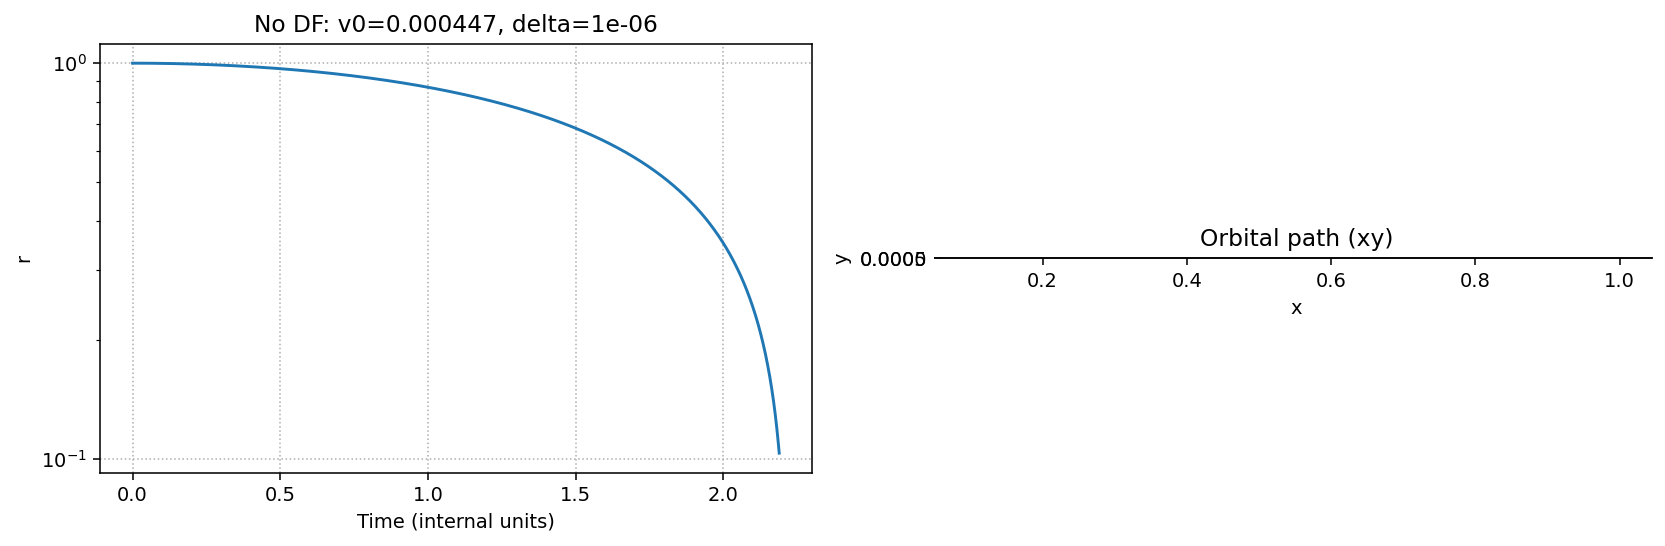

In [47]:
# Part A
ts, ys, v0 = part_a_set_delta_and_test(delta_try=1e-6)

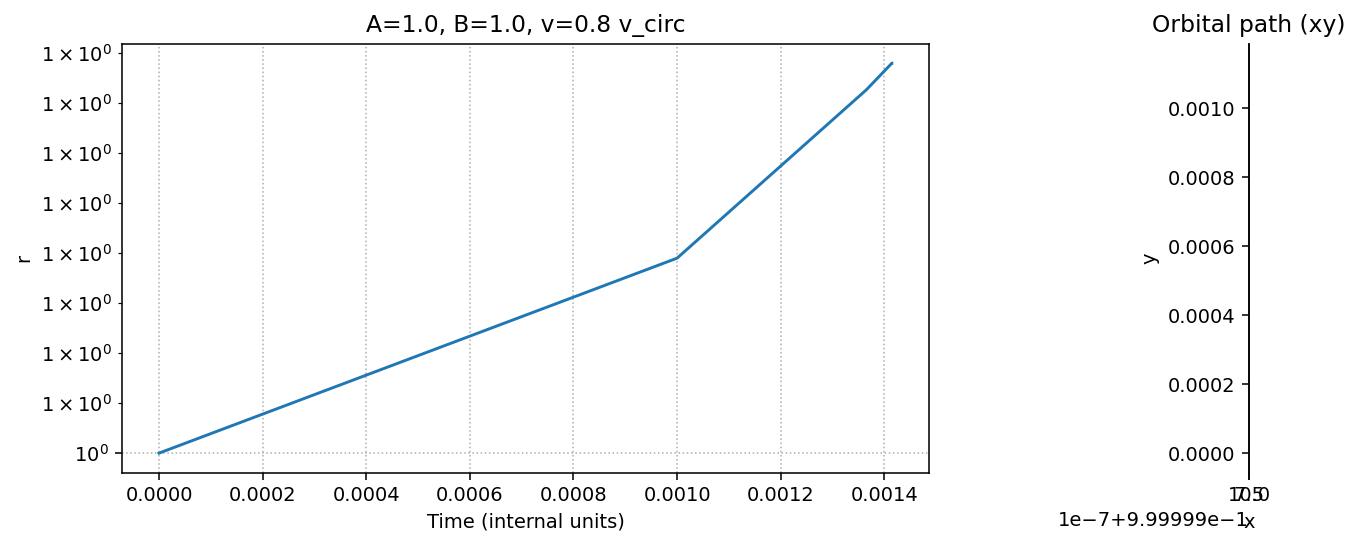

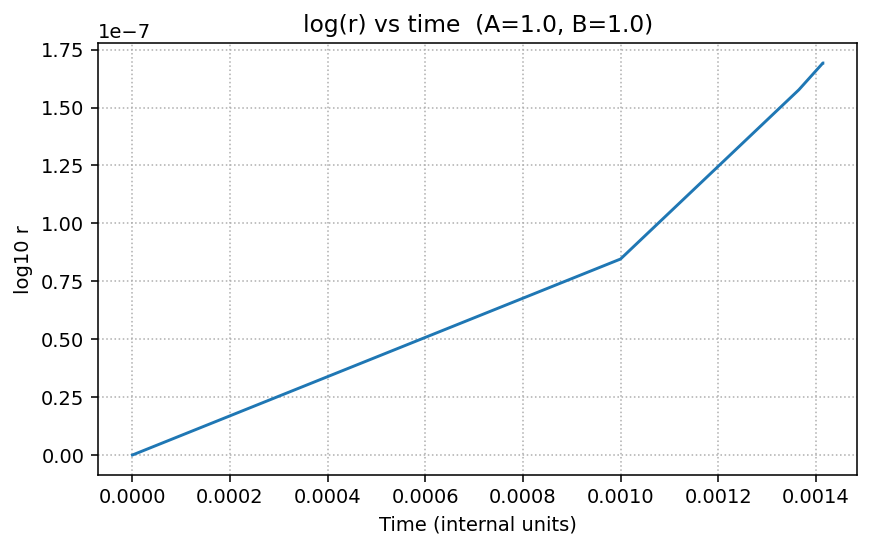

(array([0.        , 0.001     , 0.00136533, 0.00140962, 0.00141405,
        0.00141449, 0.00141454, 0.00141454, 0.00141454, 0.00141454,
        0.00141454]),
 array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          8.00000000e-01],
        [ 9.99999875e-01,  7.99735416e-04, -2.49917250e-04,
          7.99470797e-01],
        [ 9.99999767e-01,  1.09177337e-03, -3.41179006e-04,
          7.99277410e-01],
        [ 9.99999752e-01,  1.12716842e-03, -3.52239944e-04,
          7.99253967e-01],
        [ 9.99999750e-01,  1.13070787e-03, -3.53346020e-04,
          7.99251622e-01],
        [ 9.99999750e-01,  1.13106182e-03, -3.53456627e-04,
          7.99251388e-01],
        [ 9.99999750e-01,  1.13109961e-03, -3.53468438e-04,
          7.99251363e-01],
        [ 9.99999750e-01,  1.13110008e-03, -3.53468585e-04,
          7.99251362e-01],
        [ 9.99999750e-01,  1.13110026e-03, -3.53468641e-04,
          7.99251362e-01],
        [ 9.99999750e-01,  1.13110026e-03, -3.53468641e-04,

In [48]:
# Part B
part_b_orbit_with_AB(A=1.0, B=1.0, v_frac_of_circ=0.8, show_plot=True)

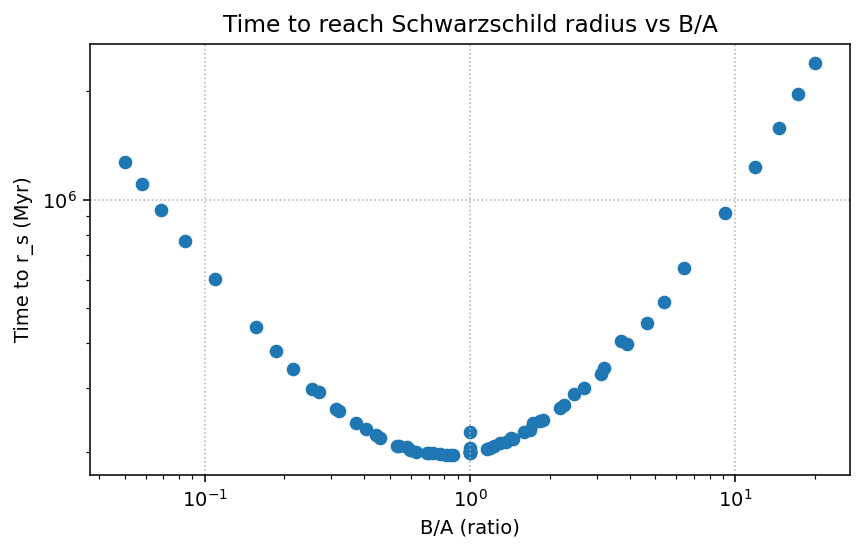

In [34]:
# part c
delta = max(delta, 1e-6)

ratio_arr, t_arr = part_c_time_to_schwarzschild_vs_ratio(A_vals=np.linspace(0.5,10,8),
                                                        B_vals=np.linspace(0.5,10,8),
                                                        v_frac=0.8, delta=1e-8)


In [35]:
v_fracs, t_results = part_d_dependence_on_initial_velocity(A=1.0, B=1.0,
                                                            v_fracs=[0.6,0.7,0.8,0.9],
                                                            delta=1e-8)


ys shape: (1774, 4)
First row: [1.00000000e+00 0.00000000e+00 0.00000000e+00 4.47214993e-04]
Last row: [ 1.03399541e-01  3.85142004e-04 -2.08220227e+00 -3.43065896e-03]


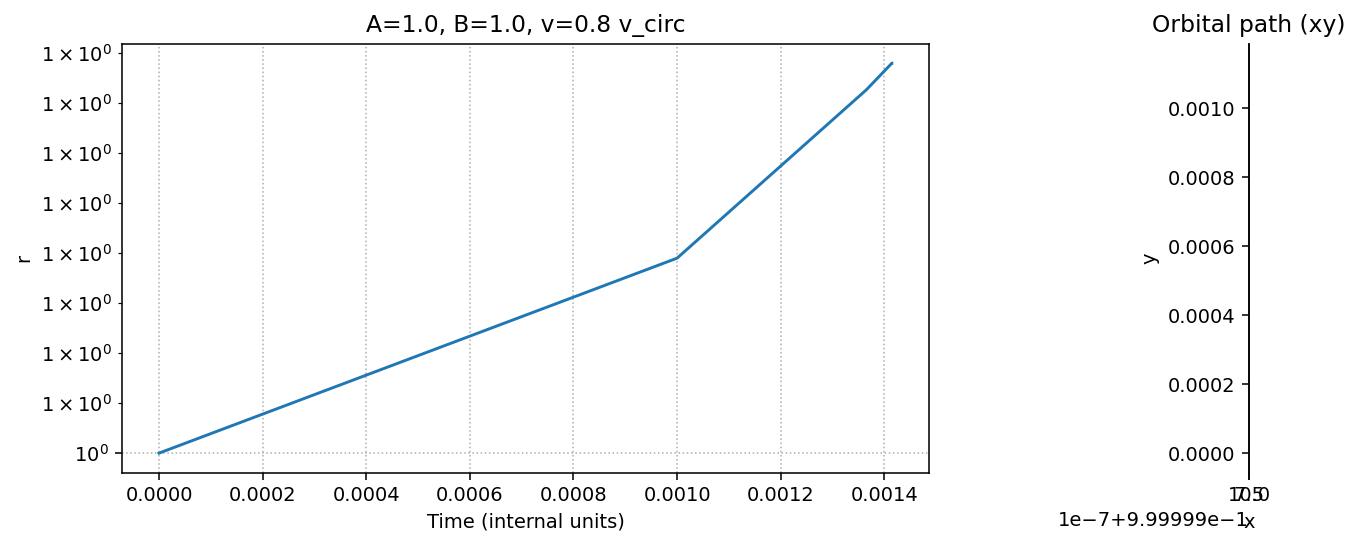

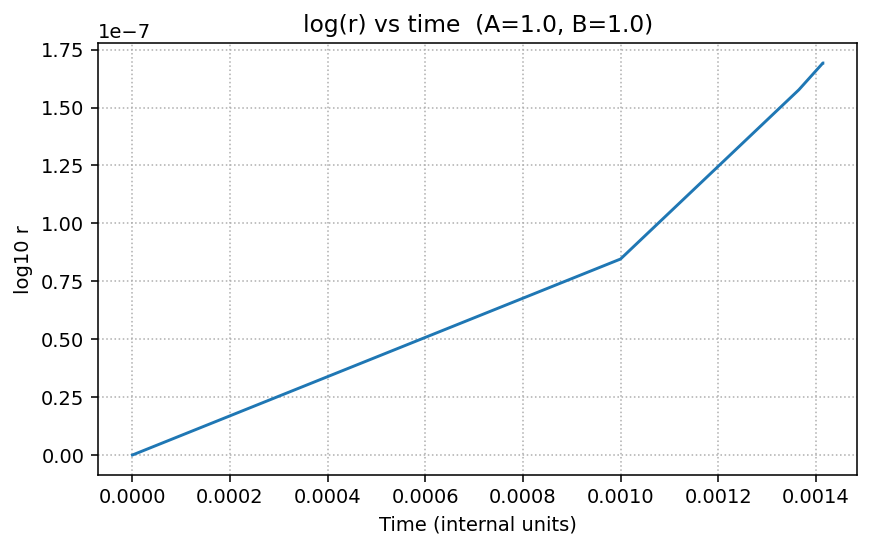

ts range: 0.0 -> 0.0014145371233031175  (#points: 11 )
r range: 0.9999997499636661 -> 1.0
phi range (rad): 0.0 -> 0.0011311002591195207
x range: 0.9999991102699962 -> 1.0
y range: 0.0 -> 0.0011310997351174565


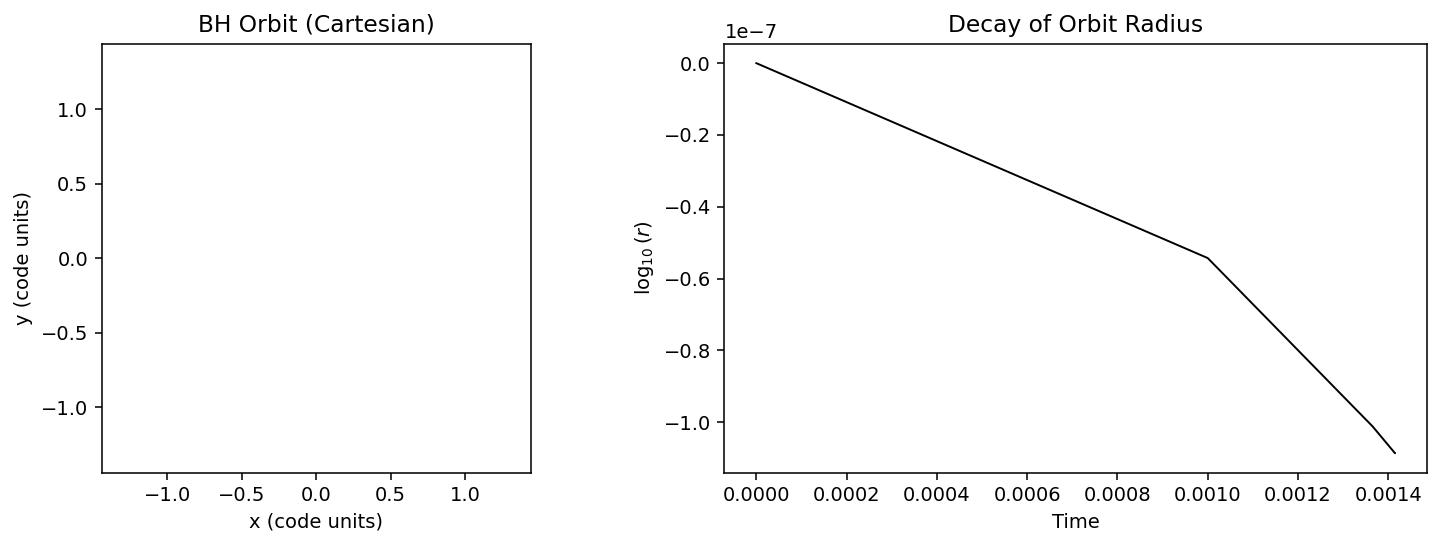

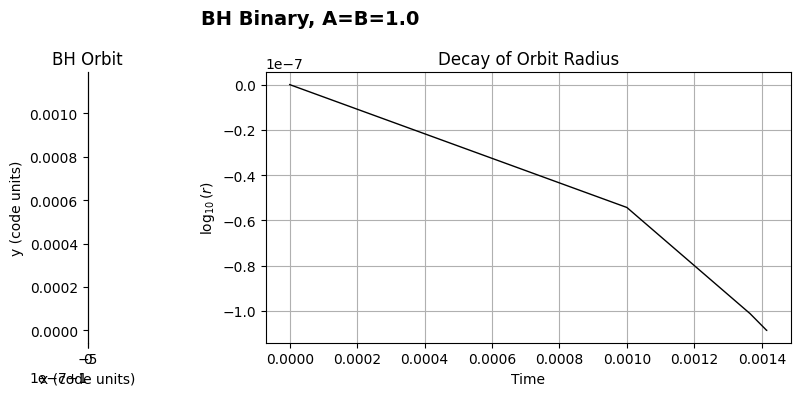

In [49]:
def plot_bh_orbit(ts, ys, title="BH Binary, A=B=1.0"):
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract from polar coordinates
    r = ys[:, 0]
    phi = ys[:, 1]
    vr = ys[:, 2]
    vphi = ys[:, 3]

    # Convert to Cartesian for plotting
    x = r * np.cos(phi)
    y = r * np.sin(phi)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left: Orbit
    ax = axes[0]
    ax.plot(x, y, color='black', lw=1)
    ax.set_xlabel("x (code units)")
    ax.set_ylabel("y (code units)")
    ax.set_title("BH Orbit")
    ax.grid(True)
    ax.set_aspect('equal', 'box')

    # Right: Orbit radius decay
    axes[1].plot(ts, np.log10(r), color='black', lw=1)
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel(r"$\log_{10}(r)$")
    axes[1].set_title("Decay of Orbit Radius")
    axes[1].grid(True)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("ys shape:", ys.shape)
print("First row:", ys[0])
print("Last row:", ys[-1])

ts, ys = part_b_orbit_with_AB(A=1.0, B=1.0, v_frac_of_circ=0.8, show_plot=False)
# diagnostic prints
print("ts range:", ts[0], "->", ts[-1], " (#points:", len(ts), ")")
print("r range:", np.min(ys[:,0]), "->", np.max(ys[:,0]))
print("phi range (rad):", ys[0,1], "->", ys[-1,1])

# convert polar -> cartesian
r = ys[:,0]
phi = ys[:,1]
x = r * np.cos(phi)
y = r * np.sin(phi)

# inspect x,y ranges
print("x range:", np.min(x), "->", np.max(x))
print("y range:", np.min(y), "->", np.max(y))

# decide sensible plot limits (centered around origin)
max_extent = max(np.max(np.abs(x)), np.max(np.abs(y)), 1.2)
lim = 1.2 * max_extent

fig, axes = plt.subplots(1,2, figsize=(11,4), dpi=140)
ax0, ax1 = axes

ax0.plot(x, y, color='k', lw=0.9)
ax0.set_aspect('equal', 'box')
ax0.set_xlim(-lim, lim)
ax0.set_ylim(-lim, lim)
ax0.set_xlabel('x (code units)')
ax0.set_ylabel('y (code units)')
ax0.set_title('BH Orbit (Cartesian)')

ax1.plot(ts, np.log10(r), color='k', lw=1.0)
ax1.set_xlabel('Time')
ax1.set_ylabel(r'$\log_{10}(r)$')
ax1.set_title('Decay of Orbit Radius')

plt.tight_layout()
plt.show()
plot_bh_orbit(ts, ys, title="BH Binary, A=B=1.0")

ts range: 0.0 -> 4.4817146838241335  (#points: 51180 )
r range: 0.09931597464187684 -> 1.0
phi range (rad): 0.0 -> 0.13746463472802292
x range: 0.09837908792355475 -> 1.0
y range: 0.0 -> 0.49501165249899126


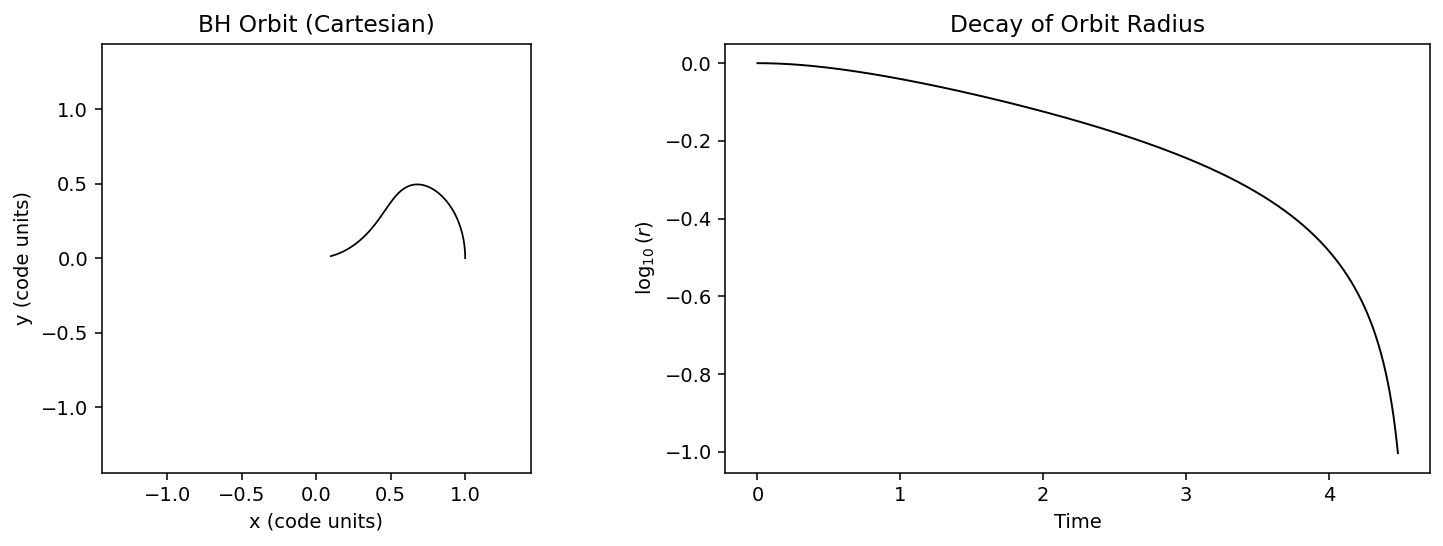

In [44]:
# compute circular speed and a longer t_final
r0 = 1.0
v_circ = np.sqrt(G * M / r0)   # should be 1.0 in your units
v0 = 0.8 * v_circ
y0 = np.array([r0, 0.0, 0.0, v0])   # polar-state format your code expects
# integrate for ~5-10 orbits: P ~ 2*pi*(a)^(3/2) ~ 2*pi
t_final = 6.28 * 8   # ~8 orbits

ts, ys = integrate_orbit(y0, t0=0.0, h_init=1e-3, t_final=t_final, delta=1e-6, A=1.0, B=1.0, r_stop=r_schw, print_steps=False)
# then run the plotting block above

# diagnostic prints
print("ts range:", ts[0], "->", ts[-1], " (#points:", len(ts), ")")
print("r range:", np.min(ys[:,0]), "->", np.max(ys[:,0]))
print("phi range (rad):", ys[0,1], "->", ys[-1,1])

# convert polar -> cartesian
r = ys[:,0]
phi = ys[:,1]
x = r * np.cos(phi)
y = r * np.sin(phi)

# inspect x,y ranges
print("x range:", np.min(x), "->", np.max(x))
print("y range:", np.min(y), "->", np.max(y))

# decide sensible plot limits (centered around origin)
max_extent = max(np.max(np.abs(x)), np.max(np.abs(y)), 1.2)
lim = 1.2 * max_extent

fig, axes = plt.subplots(1,2, figsize=(11,4), dpi=140)
ax0, ax1 = axes

ax0.plot(x, y, color='k', lw=0.9)
ax0.set_aspect('equal', 'box')
ax0.set_xlim(-lim, lim)
ax0.set_ylim(-lim, lim)
ax0.set_xlabel('x (code units)')
ax0.set_ylabel('y (code units)')
ax0.set_title('BH Orbit (Cartesian)')

ax1.plot(ts, np.log10(r), color='k', lw=1.0)
ax1.set_xlabel('Time')
ax1.set_ylabel(r'$\log_{10}(r)$')
ax1.set_title('Decay of Orbit Radius')

plt.tight_layout()
plt.show()


phi range: 0.137 rad  (0.02 orbits)


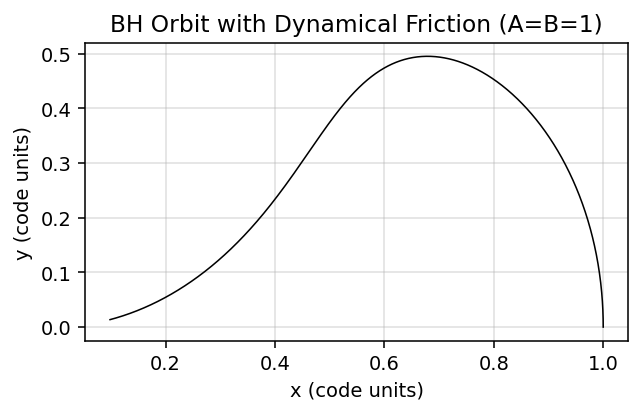

In [45]:
# rerun integration for a longer duration
t_final = 100.0  # ~16 orbits; increase if it still looks short
ts, ys = integrate_orbit(
    y0=np.array([1.0, 0.0, 0.0, 0.8]), 
    t0=0.0, 
    h_init=1e-3, 
    t_final=t_final,
    delta=1e-6,
    A=1.0, 
    B=1.0, 
    r_stop=1e-7,
    print_steps=False
)

# convert to Cartesian
r = ys[:,0]
phi = ys[:,1]
x = r * np.cos(phi)
y = r * np.sin(phi)

print(f"phi range: {phi[-1]:.3f} rad  ({phi[-1]/(2*np.pi):.2f} orbits)")

# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5), dpi=140)
ax.plot(x, y, color='k', lw=0.8)
ax.set_aspect('equal', 'box')
ax.set_xlabel('x (code units)')
ax.set_ylabel('y (code units)')
ax.set_title('BH Orbit with Dynamical Friction (A=B=1)')
ax.grid(True, alpha=0.4)
plt.show()
